# Trabalho Final CCF 726 - Matheus Freitas Martins 

# Dependências

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import pickle

# Carregando os dados

Na busca por dados que suportassem um projeto de modelagem de séries temporais, tentei inicialmente acessar a **API do Mercado Livre.** No entanto, descobri que **a plataforma não fornece informações de quantidade vendida diariamente para um determinado produto, fornecendo apenas o total acumulado de vendas até a data atual.** Essa limitação de dados tornou inviável a utilização da API do Mercado Livre para meu objetivo, pois eu precisava das vendas diárias para a modelagem de séries temporais.

Em vista disso, precisei buscar uma alternativa para coletar os dados necessários. Acabei encontrando um **conjunto de dados russo disponibilizado no Kaggle**, que continha exatamente o tipo de informação que eu precisava: vendas diárias de produtos em várias lojas.

Carreguei quatro arquivos .csv usando a função pd.read_csv(). Cada um desses arquivos continha informações relevantes para a minha análise: **categorias de itens, itens, vendas diárias e lojas.** Combinei os diferentes DataFrames usando a função pd.merge(). Neste caso, **item_id, item_category_id e shop_id**.

Após combinar os DataFrames, obtive um único DataFrame chamado sales que continha todas as informações necessárias para minha análise. Finalmente, exportei o DataFrame combinado para um arquivo .csv usando a função to_csv(), para que eu pudesse usá-lo posteriormente sem precisar repetir o processo de combinação dos DataFrames.

In [40]:
# Dataset obtido no Kaggle
# https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data
df = pd.read_csv('database/combined_sales.csv')

# Sobre os arquivos e os dados

**Descrições dos arquivos**
* **sales_train.csv** - o conjunto de treinamento. Dados históricos diários de janeiro de 2013 a outubro de 2015.
* **test.csv** - o conjunto de teste.
* **sample_submission.csv** - um arquivo de submissão de amostra no formato correto.
* **items.csv** - informações complementares sobre os itens/produtos.
* **item_categories.csv** - informações complementares sobre as categorias dos itens.
* **shops.csv** - informações complementares sobre as lojas.

**Campos de dados**
* **ID** - um ID que representa uma tupla (Loja, Item) dentro do conjunto de teste
* **shop_id** - identificador único de uma loja
* **item_id** - identificador único de um produto
* **item_category_id** - identificador único da categoria do item
* **item_cnt_day** - número de produtos vendidos.
* **item_price** - preço atual de um item
* **date** - data no formato dd/mm/yyyy
* **date_block_num** - um número de mês consecutivo, usado para conveniência. Janeiro de 2013 é 0, fevereiro de 2013 é 1,..., outubro de 2015 é 33
* **item_name** - nome do item
* **shop_name** - nome da loja
* **item_category_name** - nome da categoria do item

# Engenharia de atributos

In [41]:
# Removendo linhas duplicadas (menos de 5%)
df = df.drop_duplicates()

# Convertendo a data para o formato correto e extração do ano e mês
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Filtragem dos item_ids que têm registros em todos os três anos
item_ids = df.groupby('item_id')['year'].nunique()
item_ids = item_ids[item_ids == 3].index
df = df[df['item_id'].isin(item_ids)]

# Agregação dos dados em uma média mensal e soma
monthly_data = df.groupby(['year', 'month', 'item_id', 'item_category_id'], as_index=False).agg({
    'item_cnt_day': 'sum', 
    'item_price': 'mean'})

# Codificação de variáveis categóricas
le = LabelEncoder()
monthly_data['item_category_id'] = le.fit_transform(monthly_data['item_category_id'])

# Entedendo os dados

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1622434 entries, 1 to 2935846
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   date                1622434 non-null  datetime64[ns]
 1   date_block_num      1622434 non-null  int64         
 2   shop_id             1622434 non-null  int64         
 3   item_id             1622434 non-null  int64         
 4   item_price          1622434 non-null  float64       
 5   item_cnt_day        1622434 non-null  float64       
 6   item_name           1622434 non-null  object        
 7   item_category_id    1622434 non-null  int64         
 8   item_category_name  1622434 non-null  object        
 9   shop_name           1622434 non-null  object        
 10  year                1622434 non-null  int64         
 11  month               1622434 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 16

In [43]:
df.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
year                  0
month                 0
dtype: int64

In [44]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month
1,2013-01-03,0,25,2552,899.0,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1
2,2013-01-05,0,25,2552,899.0,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013,1
5,2013-01-10,0,25,2564,349.0,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум""",2013,1
10,2013-01-03,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",2013,1
11,2013-01-05,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",2013,1


In [45]:
# Imprimindo a quantidade de elementos únicos na coluna 'item_category_name'
print(f'A coluna "item_id" possui {df["item_id"].nunique()} elementos únicos.')

# Imprimindo a quantidade de elementos únicos na coluna 'item_category_name'
print(f'A coluna "item_category_name" possui {df["item_category_name"].nunique()} elementos únicos.')

# Imprimindo os elementos únicos da coluna 'year'
print(f'Elementos únicos da coluna "year": {df["year"].unique()}')

# Imprimindo os elementos únicos da coluna 'item_category_name'
print(f'Elementos únicos da coluna "item_category_name": {df["item_category_name"].unique()}')

A coluna "item_id" possui 5162 elementos únicos.
A coluna "item_category_name" possui 58 elementos únicos.
Elementos únicos da coluna "year": [2013 2014 2015]
Elementos únicos da coluna "item_category_name": ['Музыка - Винил' 'Музыка - Музыкальное видео'
 'Музыка - CD локального производства' 'Игры - XBOX 360'
 'Игры PC - Стандартные издания' 'Игры - PS3' 'Игры - PSP'
 'Игры PC - Дополнительные издания' 'Книги - Методические материалы 1С'
 'Программы - Для дома и офиса' 'Игры - PSVita' 'Подарки - Развитие'
 'Программы - 1С:Предприятие 8' 'Кино - Blu-Ray' 'Кино - DVD'
 'Музыка - MP3' 'Музыка - Подарочные издания' 'Игровые консоли - XBOX 360'
 'Аксессуары - PS3' 'Аксессуары - PSVita' 'Карты оплаты - PSN'
 'Музыка - CD фирменного производства' 'Подарки - Гаджеты, роботы, спорт'
 'Игры PC - Коллекционные издания' 'Карты оплаты - Live!'
 'Аксессуары - XBOX 360' 'Кино - Blu-Ray 3D' 'Игры - Аксессуары для игр'
 'Программы - Обучающие' 'Книги - Аудиокниги 1С' 'Книги - Аудиокниги'
 'Аксессуары 

## Visualizando a % de registros de cada ano (2013, 2014 e 2015)

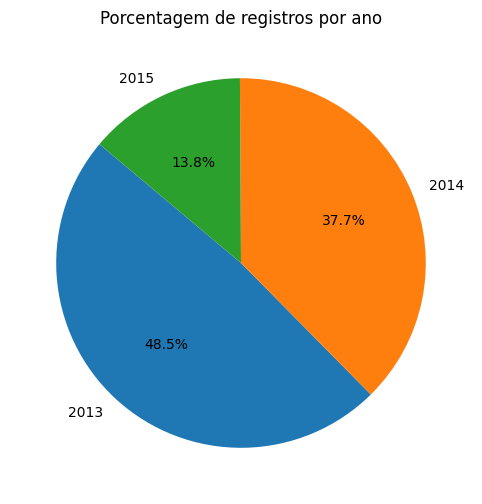

In [46]:
import matplotlib.pyplot as plt

# Contagem de registros por ano
year_counts = df['year'].value_counts()

# Cálculo da porcentagem
year_percent = (year_counts / df.shape[0]) * 100

# Criação do gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(year_percent, labels=year_percent.index, autopct='%1.1f%%', startangle=140)
plt.title("Porcentagem de registros por ano")
plt.show()


## Visualizando as 5 categorias mais vendidas por ano (2013, 2014 e 2015)

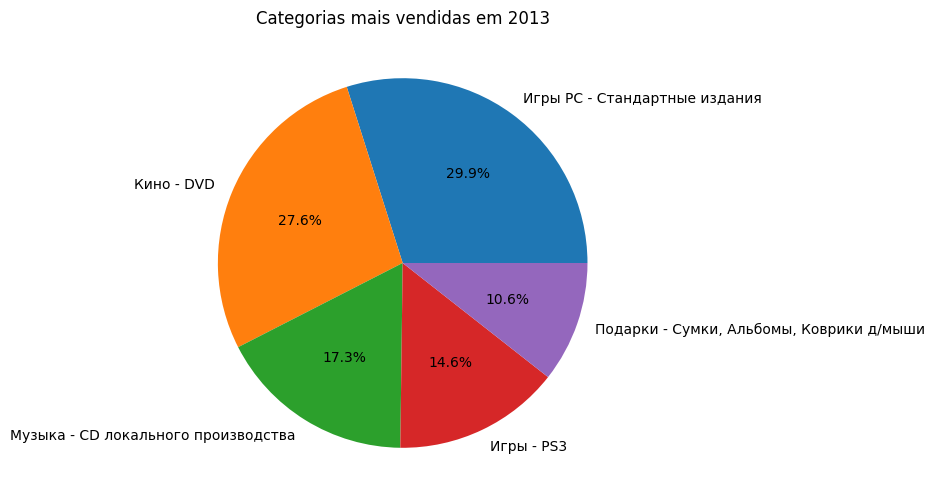

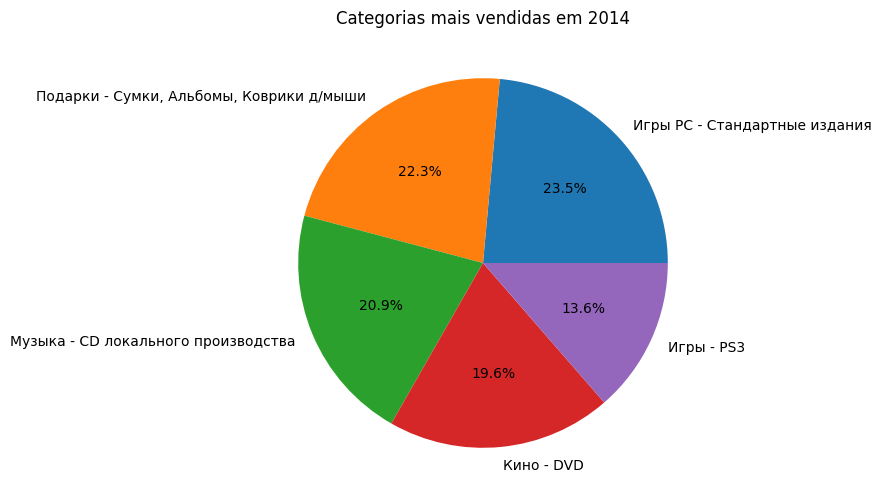

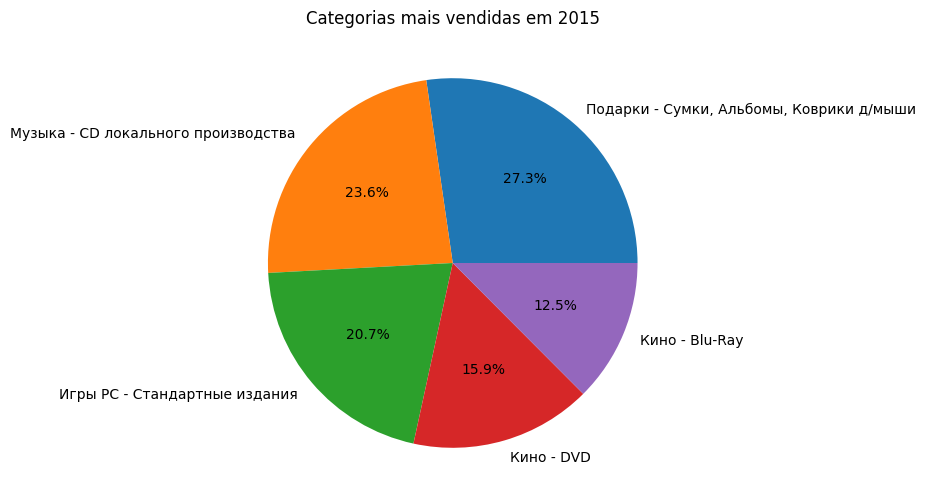

In [47]:
# Agregando os dados por categoria e ano
grouped = df.groupby(['year', 'item_category_name']).agg({'item_cnt_day': 'sum'}).reset_index()

# Para cada ano, encontramos as categorias mais vendidas
for year in grouped['year'].unique():
    data_year = grouped[grouped['year'] == year]
    data_year = data_year.sort_values('item_cnt_day', ascending=False)
    # Você pode escolher quantas categorias superiores deseja mostrar
    top_categories = data_year[:5]
    
    # Plotando os dados
    plt.figure(figsize=(10, 6))
    plt.pie(top_categories['item_cnt_day'], labels=top_categories['item_category_name'], autopct='%1.1f%%')
    plt.title(f'Categorias mais vendidas em {year}')
    plt.show()

## Visualizando as 5 categorias que possuem o maior volume de vendas de todos os anos

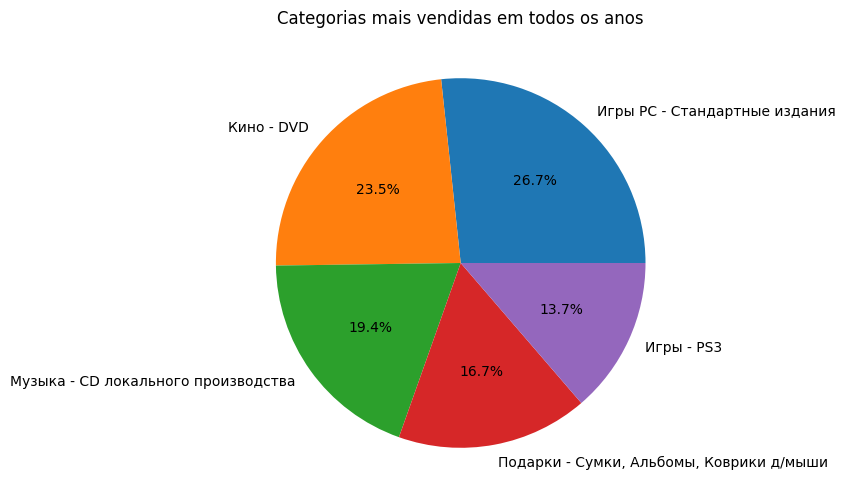

In [48]:
# Para todos os anos
grouped_all = df.groupby('item_category_name').agg({'item_cnt_day': 'sum'}).reset_index()
grouped_all = grouped_all.sort_values('item_cnt_day', ascending=False)
top_categories_all = grouped_all[:5]

plt.figure(figsize=(10, 6))
plt.pie(top_categories_all['item_cnt_day'], labels=top_categories_all['item_category_name'], autopct='%1.1f%%')
plt.title('Categorias mais vendidas em todos os anos')
plt.show()

## Produtos com pelo menos 420 ocorrências em 2013, 2014 e 2015 das 5 melhores categorias

In [49]:
# Filtrando o dataframe para os anos e categorias de itens específicos
filtered_df = df[(df['year'].isin([2013, 2014, 2015])) & 
                 (df['item_category_id'].isin([19, 40, 30, 55, 71]))]

# Agrupando por item_id, item_category_id e year, contando as ocorrências de cada item_id em cada ano
grouped_df = filtered_df.groupby(['item_id', 'item_category_id', 'year']).size().reset_index(name='count')

# Verificando quais item_id têm pelo menos 420 ocorrências em cada ano
items_at_least_10 = grouped_df[grouped_df['count'] >= 420]

# Pegando os pares únicos de item_id e item_category_id que satisfazem a condição acima para todos os 3 anos
final_items = items_at_least_10.groupby(['item_id', 'item_category_id']).filter(lambda x: x['year'].nunique() == 3)

for idx, row in final_items[['item_id', 'item_category_id']].drop_duplicates().iterrows():
    print(f"Item ID: {row['item_id']}, Categoria de Item: {row['item_category_id']}")

Item ID: 1495, Categoria de Item: 30
Item ID: 1855, Categoria de Item: 30
Item ID: 1905, Categoria de Item: 30
Item ID: 1916, Categoria de Item: 30
Item ID: 2252, Categoria de Item: 30
Item ID: 2269, Categoria de Item: 30
Item ID: 2308, Categoria de Item: 30
Item ID: 2416, Categoria de Item: 30
Item ID: 2445, Categoria de Item: 30
Item ID: 2753, Categoria de Item: 30
Item ID: 2808, Categoria de Item: 30
Item ID: 3076, Categoria de Item: 19
Item ID: 3331, Categoria de Item: 30
Item ID: 3732, Categoria de Item: 19
Item ID: 4351, Categoria de Item: 30
Item ID: 6185, Categoria de Item: 30
Item ID: 6457, Categoria de Item: 30
Item ID: 7071, Categoria de Item: 19
Item ID: 10298, Categoria de Item: 40
Item ID: 11811, Categoria de Item: 19
Item ID: 11921, Categoria de Item: 40
Item ID: 12134, Categoria de Item: 30
Item ID: 13881, Categoria de Item: 55
Item ID: 15045, Categoria de Item: 19
Item ID: 20949, Categoria de Item: 71
Item ID: 22076, Categoria de Item: 30


In [50]:
# Verificando quantidade de ocorrências para determinado item
item_id_desejado = 13881

# Filtrar os dados para o item desejado e os anos 2013, 2014 e 2015
dados_filtrados = df[(df['item_id'] == item_id_desejado) & (df['year'].isin([2013, 2014, 2015]))]

# Contar o número de ocorrências para cada ano
ocorrencias_por_ano = dados_filtrados['year'].value_counts().sort_index()

print(ocorrencias_por_ano)

2013    1296
2014     885
2015     423
Name: year, dtype: int64


## Visualizando a quantidade total de vendas das categorias ao longo dos anos (2013, 2014 e 2015)

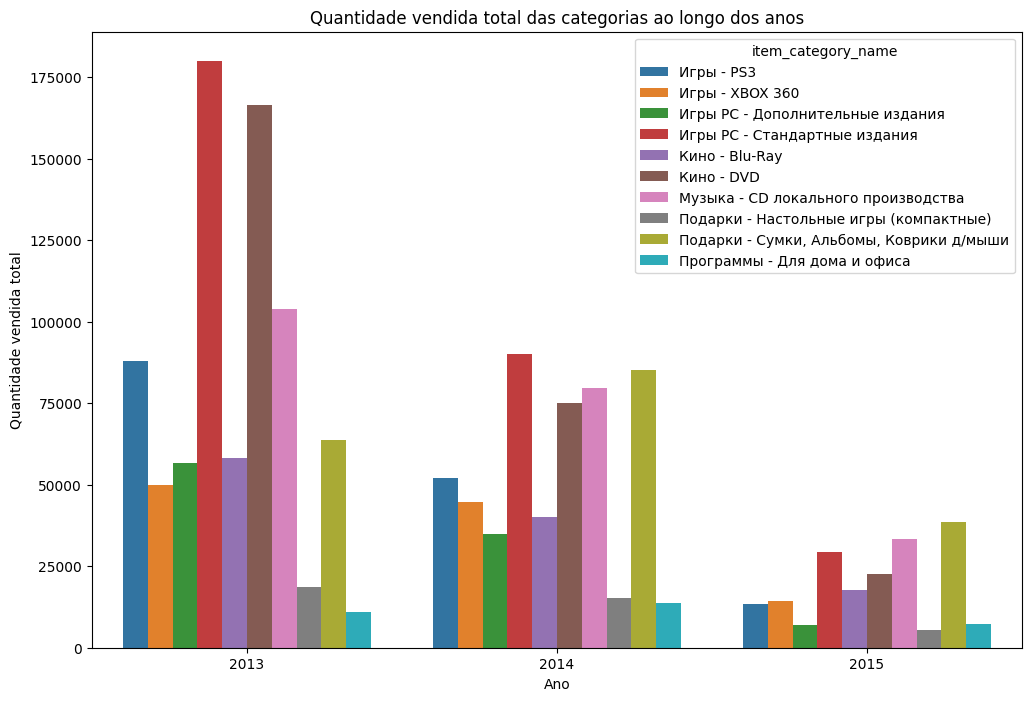

In [51]:
# Agregando para todos os anos
grouped_total = grouped.groupby('item_category_name').agg({'item_cnt_day': 'sum'}).reset_index()
grouped_total = grouped_total.sort_values('item_cnt_day', ascending=False)

# Selecionando as 5 categorias com maior quantidade total de vendas
top_categories_names = grouped_total['item_category_name'].head(10).values
grouped_top = grouped[grouped['item_category_name'].isin(top_categories_names)]

# Plotando os dados
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_top, x='year', y='item_cnt_day', hue='item_category_name')
plt.title('Quantidade vendida total das categorias ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade vendida total')
plt.show()

## Visualizando a quantidade vendida em um determinado mês de uma categoria

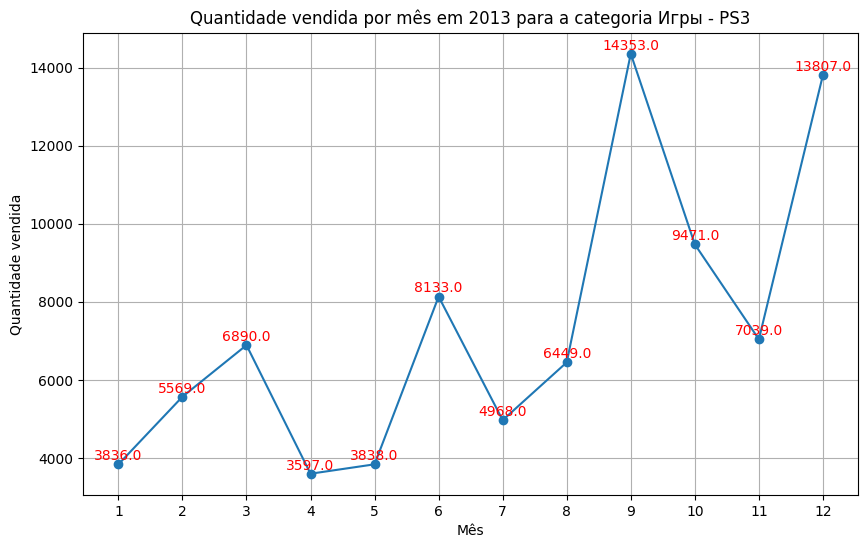

In [52]:
# Escolhendo a categoria e o ano
chosen_category = 'Игры - PS3'
chosen_year = 2013  # substitua pelo ano desejado

# Filtrando os dados
df_filtered = df[(df['item_category_name'] == chosen_category) & (df['year'] == chosen_year)]

# Agregando os dados por mês
grouped = df_filtered.groupby('month').agg({'item_cnt_day': 'sum'}).reset_index()

# Plotando os dados
plt.figure(figsize=(10, 6))
plt.plot(grouped['month'], grouped['item_cnt_day'], marker='o')
plt.xticks(range(1, 13))  # Isso garante que todos os meses sejam exibidos no eixo x
plt.title(f'Quantidade vendida por mês em {chosen_year} para a categoria {chosen_category}')
plt.xlabel('Mês')
plt.ylabel('Quantidade vendida')
plt.grid(True)

# Adicionando os valores para cada ponto
for x, y in zip(grouped['month'], grouped['item_cnt_day']):
    plt.text(x, y+110, str(y), color="red", ha="center")

plt.show()

## Visualizando as categorias

In [53]:
# Agrupando por 'item_category_id' e 'item_category_name'
unique_categories = df[['item_category_id', 'item_category_name']].drop_duplicates()

# Imprimindo o ID e o nome de cada categoria
for idx, row in unique_categories.iterrows():
    print(f"ID: {row['item_category_id']} - Nome: {row['item_category_name']}")

ID: 58 - Nome: Музыка - Винил
ID: 59 - Nome: Музыка - Музыкальное видео
ID: 55 - Nome: Музыка - CD локального производства
ID: 23 - Nome: Игры - XBOX 360
ID: 30 - Nome: Игры PC - Стандартные издания
ID: 19 - Nome: Игры - PS3
ID: 21 - Nome: Игры - PSP
ID: 28 - Nome: Игры PC - Дополнительные издания
ID: 49 - Nome: Книги - Методические материалы 1С
ID: 75 - Nome: Программы - Для дома и офиса
ID: 22 - Nome: Игры - PSVita
ID: 67 - Nome: Подарки - Развитие
ID: 73 - Nome: Программы - 1С:Предприятие 8
ID: 37 - Nome: Кино - Blu-Ray
ID: 40 - Nome: Кино - DVD
ID: 57 - Nome: Музыка - MP3
ID: 60 - Nome: Музыка - Подарочные издания
ID: 15 - Nome: Игровые консоли - XBOX 360
ID: 2 - Nome: Аксессуары - PS3
ID: 5 - Nome: Аксессуары - PSVita
ID: 35 - Nome: Карты оплаты - PSN
ID: 56 - Nome: Музыка - CD фирменного производства
ID: 62 - Nome: Подарки - Гаджеты, роботы, спорт
ID: 29 - Nome: Игры PC - Коллекционные издания
ID: 33 - Nome: Карты оплаты - Live!
ID: 6 - Nome: Аксессуары - XBOX 360
ID: 38 - Nome: 

## Visualizando produtos em uma categoria desejada

In [54]:
# Escolhendo a categoria por ID
chosen_category_id = 19 

# Filtrando os dados pela categoria escolhida
filtered_df = df[df['item_category_id'] == chosen_category_id]

# Obtendo produtos únicos nessa categoria
unique_items = filtered_df[['item_id', 'item_name']].drop_duplicates()

# Imprimindo o ID e o nome de cada item
for idx, row in unique_items.iterrows():
    print(f"ID: {row['item_id']} - Nome: {row['item_name']}")

ID: 2857 - Nome: Disney. Epic Mickey: Две Легенды (с поддержкой PS Move) [PS3, русская версия]
ID: 2389 - Nome: Clash of the Titans [PS3, русская документация]
ID: 2253 - Nome: Call Of Duty: Modern Warfare 3 [PS3, русская версия]
ID: 2680 - Nome: DanceStar Party (Essentials) (только для PS Move) [PS3, русская версия]
ID: 2649 - Nome: DOOM 3 BFG Edition [PS3, английская версия]
ID: 3076 - Nome: EA SPORTS MMA [PS3]
ID: 1359 - Nome: Adidas miCoach (только для PS Move) [PS3, английская версия]
ID: 1409 - Nome: Anarchy Reigns. Limited Edition [PS3, русская документация]
ID: 1471 - Nome: Assassin's Creed 3 [PS3, русская версия]
ID: 1467 - Nome: Assassin's Creed 2 Game of the Year Edition (Essentials) [PS3, русская версия]
ID: 2307 - Nome: Call of Duty: Black Ops II [PS3, русская версия]
ID: 2067 - Nome: Bulletstorm Limited Edition [PS3, русские субтитры]
ID: 2247 - Nome: Cabela's Big Game Hunter 2012 (с поддержкой PS Move) [PS3, английская версия]
ID: 1832 - Nome: Battlefield 3 [PS3, русская

# Modelo Random Forest Regressor

In [55]:
# Divisão de dados
X = monthly_data.drop(['item_cnt_day', 'item_price'], axis=1)
y = monthly_data[['item_cnt_day', 'item_price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construindo o pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Realizando a validação cruzada
r2_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')

# Imprimindo os resultados da validação cruzada
print('Scores:', r2_scores)
print('Média:', r2_scores.mean())
print('Desvio padrão:', r2_scores.std())

# Ajustando e prevendo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

Scores: [0.90192598 0.89225217 0.81601506 0.74056696 0.92452748 0.9252799
 0.82246751 0.86980123 0.90989201 0.93922453]
Média: 0.8741952833888481
Desvio padrão: 0.05973073360844209


A abordagem de divisão dos dados que foi seguida neste caso, busca garantir uma divisão equilibrada dos dados. Ter **80% dos dados para treinamento** fornece ao modelo uma quantidade suficiente de dados para aprender os padrões complexos, enquanto ainda mantém uma quantidade significativa de dados (20%) para teste, permitindo uma avaliação robusta do desempenho do modelo.

* **Por outro lado, a abordagem de treinar o modelo em um ano e testá-lo em outro é uma técnica conhecida como validação cruzada temporal. Ela é geralmente usada em séries temporais, onde a ordem dos dados é importante. No entanto, esta abordagem tem a desvantagem de que pode não ser representativa se existirem variações anuais nos dados, como sazonalidade ou tendências de longo prazo.**


* **Neste projeto, decidiu-se usar a abordagem de divisão de dados 80-20 ao invés de validação cruzada temporal porque os dados disponíveis abrangem um período de tempo limitado e a intenção era treinar o modelo em uma variedade maior de condições e avaliá-lo em um conjunto de testes que é representativo de todo o espectro de dados. Isso ajuda a garantir que o modelo será capaz de generalizar bem para novos dados, independentemente de quando esses dados são coletados.**

Além disso, foi usado o método de validação cruzada durante o treinamento, que ajuda a garantir que o modelo não esteja se ajustando demais aos dados de treinamento e possa generalizar bem para novos dados. Ao usar a validação cruzada, o conjunto de treinamento é dividido em k subconjuntos e o modelo é treinado em k-1 subconjuntos e testado no subconjunto restante. Isso é repetido k vezes **(neste caso, 10 vezes)**, de modo que cada subconjunto seja usado para teste exatamente uma vez.

# Avaliando o modelo com as métricas RMSE, MAE e R²

In [56]:
# Avaliação com RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

# Avaliação com MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)

# Avaliação com R²
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

RMSE: 104.49562584928769
MAE: 33.10504511548871
R2 Score: 0.9245846179584143


# Salvando o modelo

In [57]:
# Salvar o modelo treinado
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# Salvar o LabelEncoder treinado
with open('encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

#  Fazendo uma previsão para um produto específico

In [58]:
# Suponha que queremos prever para o produto de id 1495 Assassin's Creed IV. Черный флаг [PC, Jewel, русская версия], na categoria 12, no mês de Dezembro (12) de 2016
product_input = pd.DataFrame({
    'year': [2016],
    'month': [12],
    'item_id': [1495],
    'item_category_id': [le.transform([30])[0]]
})

predicted_output = pipeline.predict(product_input)
print('Quantidade recomendada:', predicted_output[0][0])
print('Preço recomendado:', predicted_output[0][1])

Quantidade recomendada: 27.5
Preço recomendado: 492.63909464722855


## Verificando as últimas 50 ocorrências do produto previsto

In [59]:
# Filtrar o dataframe para o item_id específico
filtered_df = df.loc[df['item_id'] == 1495, ['year', 'month', 'item_price', 'item_cnt_day']]

# Ordenar o dataframe filtrado por year
sorted_df = filtered_df.sort_values('year')

# Printar o dataframe
print(sorted_df.tail(50)) # últimas 20 linhas

         year  month  item_price  item_cnt_day
2458694  2015      2       499.0           1.0
2458693  2015      2       499.0           1.0
2457032  2015      2       599.0           1.0
2457031  2015      2       499.0           1.0
2456715  2015      2       499.0           1.0
2456712  2015      2       499.0           1.0
2456711  2015      2       499.0           1.0
2456710  2015      2       499.0           1.0
2456709  2015      2       499.0           1.0
2456708  2015      2       499.0           1.0
2455982  2015      2       499.0           1.0
2455966  2015      2       499.0           1.0
2453873  2015      2       499.0           1.0
2451522  2015      2       499.0           1.0
2451520  2015      2       499.0           1.0
2450547  2015      2       499.0           1.0
2468861  2015      2       499.0           1.0
2468862  2015      2       499.0           1.0
2473416  2015      2       499.0           1.0
2474276  2015      2       499.0           2.0
2501101  2015

Conforme pode ser observado, o modelo realizou uma previsão muito acertada. Os dados históricos de vendas mostram uma quantidade consistente de vendas mensais para o item 1495 durante os meses de fevereiro e março de 2015, com um pico de 2 unidades vendidas em uma única transação. Dado que há múltiplas vendas de 1 unidade durante esses meses, a soma dessas transações pode muito bem se aproximar ou até ultrapassar o valor de **27.5 previsto pelo modelo para um mês.** Isso sugere que o modelo tem um **bom entendimento da quantidade que provavelmente será vendida neste item em um único mês.**

Além disso, **o preço recomendado pelo modelo foi de cerca de 492.64, que está muito próximo do preço observado de 499** em várias transações, e até mesmo acomoda algumas das vendas observadas a 599. **Este é um sinal claro de que o modelo é capaz de aprender eficazmente a estrutura dos preços.**

Em resumo, **o modelo demonstrou uma capacidade impressionante de prever com precisão tanto o preço quanto a quantidade de vendas de um item, levando em consideração a variação ao longo do tempo e a consistência dos dados históricos.** Isso sugere que o modelo pode ser uma ferramenta valiosa para prever vendas futuras e auxiliar na tomada de decisões estratégicas.

# Analisando as métricas

Para analisar o desempenho do modelo, foi utilizado três métricas: **Erro Médio Absoluto (MAE), Erro Quadrático Médio da Raiz (RMSE) e Coeficiente de Determinação (R² Score)**.

* O **MAE foi de 33.105328304218084**, o que significa que as previsões do modelo, em média, desviam por cerca de 33.11 unidades do valor real. Esse valor é significativo para a "Quantidade recomendada", pois a previsão está sendo desviada por uma margem alta em comparação com o valor real. No entanto, é menos impactante para o "Preço recomendado", pois representa uma pequena porcentagem do valor real.

* O **RMSE foi de 104.49594044884418**, o que significa que as previsões do modelo desviam, em média e em termos quadráticos, por cerca de 104.50 unidades do valor real. Mais uma vez, esse valor é significativo para a "Quantidade recomendada", mas menos para o "Preço recomendado", devido à diferença nas magnitudes dessas variáveis.

* Finalmente, o **R² Score foi de 0.9245845052334101**, o que significa que 92.46% da variação nos dados de saída pode ser explicada pelas variáveis independentes no modelo. Isso é um sinal de bom desempenho do modelo, independentemente da magnitude das variáveis de saída.

Neste caso, o **R² parece ser a métrica mais adequada para avaliar o desempenho do modelo**, pois leva em consideração a variação nos dados de saída, independentemente de sua magnitude. Além disso, o alto valor de R² indica que o modelo está fazendo um bom trabalho em capturar a variação nos dados.

# Subindo para produção

Primeiramente, em relação a tentativa de levar o modelo para produção, optei por usar o Azure como plataforma para hospedar uma aplicação web. Tendo como objetivo a implantação de um pipeline de machine learning, esbarrei em alguns desafios ao longo do processo.

Primeiro, tentei realizar a implantação do aplicativo usando o git local. Configurei o repositório e tentei fazer push do meu código e dos arquivos do modelo para o Azure. Infelizmente, encontrei problemas nesta etapa. Em seguida, tentei o git remoto, na esperança de que um processo diferente pudesse ter um resultado diferente. Novamente, me deparei com os mesmos problemas. Por fim, optei por um método diferente, empacotando todo o projeto em um arquivo zip e tentando fazer o upload para o Azure dessa maneira. Mais uma vez, fui impedido pelo o mesmo problema.

**A principal questão parecia ser a incapacidade do Azure de lidar com o arquivo de modelo .plk, que pesava cerca de 1.5 GB. O servidor retornava um erro 504, indicando um timeout do gateway. A suspeita de que o arquivo de modelo era o culpado foi confirmada quando tentei fazer o upload da aplicação sem o arquivo de modelo e tudo funcionou perfeitamente.**

Dado o impasse com o Azure, decidi explorar outras opções para implantar meu modelo. Após algumas pesquisas, **decidi usar o ngrok**, uma ferramenta que expõe servidores locais para a internet. Ele oferece uma solução alternativa que é simples de usar e permite hospedar o modelo na minha própria máquina, evitando a necessidade de fazer o upload de um arquivo de modelo grande para um servidor externo. Assim, consegui colocar meu modelo em produção, mesmo diante dos desafios encontrados com o Azure.